In [1]:
from glob import glob
import cv2
import numpy as np
import itertools as it
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import tifffile as tf

from scipy import ndimage, signal, spatial
from skimage import morphology

import os
import pandas as pd

from importlib import reload

import sklearn.linear_model as linear

In [14]:
boundary = ndimage.generate_binary_structure(2,2).astype(int) - 2
boundary[1,1] = -(np.sum(boundary) + 1)
unique = np.array([40, 120, 160, 200, 240], dtype=np.uint8)

struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)

rsrc = '../raw/'
src = '../proc/'
time = '4pm'
rep = 7
pidx = 3

foo = '_rep{}/plant_{:02d}/'.format(rep,pidx)

asrc = src + 'anchory/' + time + foo
psrc = src + 'prelim/' + time + foo

filenames = glob(psrc + '*.tif')

nums = np.zeros(len(filenames), dtype=int) - 1
for i in range(len(nums)):
    num = os.path.splitext(os.path.split(filenames[i])[1])[0].split('_')[-1]
    num = int(num)
    nums[i] = num
        
anums = np.argsort(nums)

In [22]:
idx = 301
print(filenames[anums[idx]])
img = tf.imread(filenames[anums[idx]])
print(img.shape)

../proc/prelim/4pm_rep7/plant_03/4pm_rep07_0302.tif
(722, 132)


In [23]:
metafile = asrc + os.path.splitext(os.path.split(filenames[anums[idx]])[1])[0] + '.csv'
meta = pd.read_csv(metafile, header = None)
lenraw = meta.iloc[0,0]
tape = meta.iloc[0,2]
peak = meta.iloc[0,3]
buffx = meta.iloc[0,4]
buffy = meta.iloc[0,5]

plant = meta.iloc[0, 6:10].values.astype(int)
pss = np.s_[plant[0]:plant[1], plant[2]:plant[3]]

ceros = meta.iloc[0, 10:14].values.astype(int)
css = np.s_[ceros[0]:ceros[1], ceros[2]:ceros[3]]
anchory = meta.iloc[0,14]
coef = meta.iloc[0,15:].values

rawx = ceros[2] + plant[2] - peak + buffy
rawy = ceros[0] + plant[0] + buffx

xvals = np.arange(lenraw)
b0 = peak + coef[0] - buffy
lines = b0 + coef[1]*(xvals - buffx)

xlen = xvals[ pss[0] ] - plant[0]
line = lines[ pss[0] ] - plant[2]

ll = line[np.arange(ceros[0],ceros[1])] - ceros[2]
xx = np.arange(ceros[1]-ceros[0])

In [24]:
v0 = np.array([coef[1], 1])
v = v0/np.linalg.norm(v0)
n = np.array([-v[1], v[0]])
p = np.array([ll[0],0])
b = np.sum(p*n)

cross = np.asarray(np.nonzero(img > 180))
dist = np.abs(cross[1]*n[0] + cross[0]*n[1] - b)
print('Min dist: {:.2f}\nMax dist: {:.2f}'.format(np.min(dist),np.max(dist)))
mask = dist < 10
print(np.sum(mask), np.sum(mask) > 10)

Min dist: 0.11
Max dist: 75.92
176 True


In [35]:
skel = np.zeros(img.shape, dtype=bool)
skel[cross[0, mask], cross[1, mask]] = True
labels,num = ndimage.label(skel, structure=ndimage.generate_binary_structure(2,2))
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
where = np.nonzero((hist/np.sum(hist) > 0.1))[0]

print(num,'components\t', len(where), 'preserved')
print(hist, np.round(hist/np.sum(hist), 2))
print('where:\t', where)

if len(where) > 1:
    merged = dict()
    coords = dict()
    for i in range(len(where)):
        coords[where[i]] = np.asarray(np.nonzero(labels == where[i] + 1))
        merged[where[i]] = []

    combs = list(it.combinations(where, 2))
    for i in range(len(combs)):
        dxy = np.min(spatial.distance.cdist(coords[combs[i][0]].T, coords[combs[i][1]].T, metric='euclidean'))
        print(combs[i], dxy, sep='\t')
        
        if dxy < 20:
            merged[combs[i][1]].append(combs[i][0])
    
    print('merge dict:\t', merged)
    
    for j,i in enumerate(where):
        k = i  
        while len(merged[k]) > 0:
            k = min(merged[k])
        print(i, '-->', k, sep='\t')
        labels[labels == i+1] = k+1
        where[j] = k
    
    where = np.unique(where)
    print('where:\t', where)

4 components	 3 preserved
[54  1 72 49] [0.31 0.01 0.41 0.28]
where:	 [0 2 3]
(0, 2)	16.0
(0, 3)	218.21548982599745
(2, 3)	130.01538370516005
merge dict:	 {0: [], 2: [0], 3: []}
0	-->	0
2	-->	0
3	-->	3
where:	 [0 3]


In [37]:
coms = np.asarray(ndimage.center_of_mass(skel, labels, where+1))
print(len(coms))
dmask = []
dcom = []

for i in range(len(coms)):
    com = coms[i]
    dd = np.sqrt(np.sum((cross - com.reshape(-1,1))**2, axis=0))
    dmask.append(dd < 40)
    foo = dd[dmask[i]]
    dcom.append(np.max(foo) + 1 - foo)

2


In [38]:
coefs = np.zeros((len(coms), 2))
angle = np.zeros(len(coms))

for i in range(len(coms)):
    X = cross[1, dmask[i]].reshape(-1,1)
    reg = linear.RANSACRegressor(random_state=0).fit(X, cross[0,dmask[i]], sample_weight = dcom[i])
    coef1 = np.diff(reg.predict([[0],[1]]))[0]
    coef0 = reg.predict([[0]])[0]
    
    w0 = np.array([1, coef1])
    w = w0/np.linalg.norm(w0)
    
    coefs[i] = [coef0, coef1]
    angle[i] = -np.sign(coef1)*np.arccos(np.abs(np.sum(w*n)))
    
print(np.rad2deg(angle))

[-78.27042188  67.32894293]


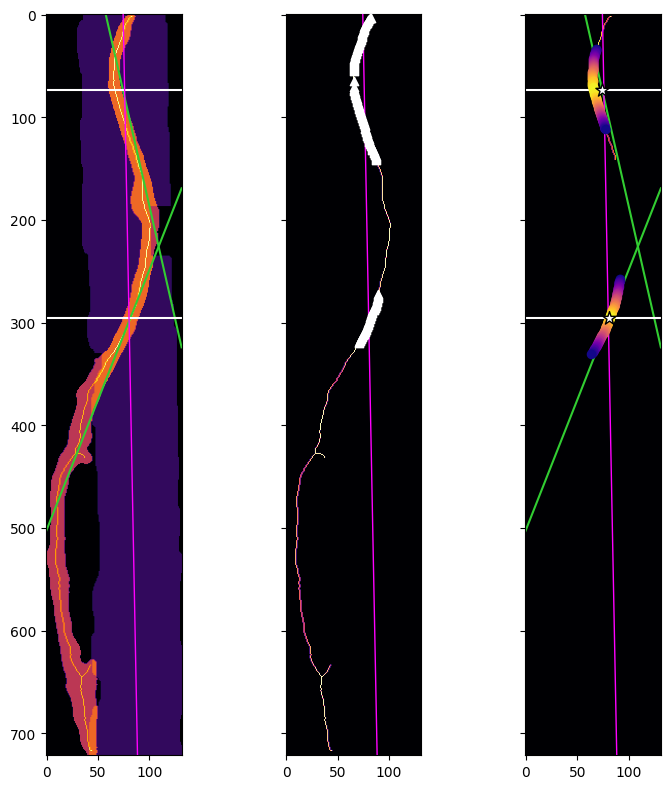

In [39]:
fig, ax = plt.subplots(1,3,figsize=(8,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(img, cmap='inferno', vmin=0, zorder = 2, origin='lower');

ax[1].imshow(img > 160, vmin=0, cmap='magma')
ax[1].scatter(cross[1, mask], cross[0, mask], c='w', marker='^', zorder=4)

ax[2].imshow(skel, cmap='inferno')
for i in range(len(coms)):
    ax[2].scatter(cross[1, dmask[i]], cross[0, dmask[i]], c=dcom[i], cmap='plasma', zorder=10 - i)
    ax[2].scatter(*np.flip(coms[i]), c='w', s=100, marker='*', zorder=11, edgecolor='k')

#ax[2].scatter(*np.flip(np.mean(coms, axis=0)), c='r', s=100, marker='^', zorder=12, edgecolor='k')

for j in [0,2]:
    for i in range(len(coms)):
        ax[j].axline(xy1 = (coms[i,1], coms[i,0]), slope = coefs[i,1], c='limegreen')
        ax[j].axhline(coms[i,0], c='w')

for i in range(len(ax)):
    ax[i].plot(ll,xx, color='magenta', lw=1, zorder=3);

fig.tight_layout()

In [10]:
order = np.argsort(coms[:,0])[::-1]
print(coms[:,0], order)
np.rad2deg(angle[order])

[52.57142857] [0]


array([5.90017061])

In [11]:
rawname = '{}{} Inc Rep {}/{} Inc Rep {} ({}).JPG'.format(rsrc, time, rep, time, rep, nums[anums[idx]])
raw = cv2.imread(rawname)


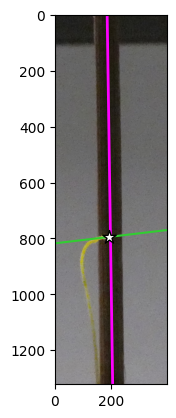

In [13]:
stick = np.s_[buffx:tape+buffx, peak-buffy:peak+buffy]

plt.imshow(raw[stick][:,:,::-1])
plt.plot(lines[stick[0]] - peak + buffy, xvals[stick[0]] - buffx, c='magenta', lw=2)

plt.scatter(coms[:,1] + rawx , coms[:,0] + rawy, c='w', s=100, marker='*', zorder=11, edgecolor='k')
for i in range(len(coms)):
    plt.axline(xy1 = (coms[i,1]+rawx, coms[i,0]+rawy), slope = coefs[i,1], c='limegreen')

In [50]:
#skel = np.zeros(img.shape, dtype=float)
#skel[cross[0], cross[1]] = np.max(dist) + 1 - dist
#pers = sorted(UF.persistence(skel),reverse=True)
#pers